Overview of the Game
Agents and Environment
Lattice Structure: The simulation consists of a 100x100 two-dimensional lattice (grid), creating a total of 10,000 agents. The lattice has periodic boundary conditions, meaning the edges wrap around to form a continuous surface without borders.

Resource Heterogeneity: Each site on the lattice is assigned a resource value, making it either a rich site or a poor site:

Rich Sites: Have a higher resource value, determined by RICH_RESOURCE = 1 + INEQUALITY_LEVEL (where INEQUALITY_LEVEL = 10, so RICH_RESOURCE = 11).
Poor Sites: Have a baseline resource value of POOR_RESOURCE = 1.
Distribution: Each site has a probability RICH_SITE_PROB = 0.2 (20%) of being rich.
Agent Strategies: Agents can adopt one of two strategies:

Cooperators ('C'): Willing to cooperate with neighbors.
Defectors ('D'): Choose to defect in interactions.
Initialization: Agents randomly select a strategy based on INITIAL_COOPERATION_PROB = 0.5, so there is an equal chance of being a cooperator or defector at the start.
Game Dynamics
Interactions: At each time step, agents interact with their immediate neighbors (up to four, in the von Neumann neighborhood: north, south, east, west).

Payoff Calculation: Agents accumulate payoffs based on their strategy and the strategies of their neighbors:

Cooperator-Cooperator (C-C): Both cooperators gain the neighbor's resource value.
Cooperator-Defector (C-D): The cooperator gains nothing; the defector gains a payoff.
Defector-Cooperator (D-C): The defector gains a payoff equal to b * resource, where b is the temptation factor.
Defector-Defector (D-D): Neither gains any payoff.
Temptation Level: Defined by TEMPTATION_LEVEL = 0.7, used to calculate b = 2 / TEMPTATION_LEVEL ≈ 2.857.
Strategy Update: After interactions:

Agents may update their strategies by comparing payoffs with a randomly selected neighbor.
If the neighbor's payoff is higher, the agent adopts the neighbor's strategy with a probability proportional to the payoff difference.
This process introduces stochastic imitation, allowing for strategy changes based on success.
Simulation Loop
The simulation runs for 100 time steps, and at each step:

Play Game: Agents interact with neighbors and calculate payoffs.
Update Strategies: Agents may adopt new strategies based on payoffs.
Record Cooperation Level: The fraction of cooperators is calculated and stored.
Visualization: The lattice is plotted at time steps 1, 50, and 100 to visualize the distribution of strategies.


Import Libs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx


Adjust parameters of simulation

In [2]:
# Adjust grid size to 100x100
GRID_SIZE = 30  # 100x100 lattice
NUM_AGENTS = GRID_SIZE * GRID_SIZE  # Total number of agents = 100^2 = 10,000
RICH_SITE_PROB = 0.2  # Fraction of rich sites
AVERAGE_SITE_PROB = 0.0  # Fraction of average sites (you can adjust as needed)
INITIAL_COOPERATION_PROB = 0.5
c = 5  # Resource contrast (c) between rich and poor sitesINEQUALITY_LEVEL
DEFECTOR_COST = 1  # A small cost or penalty for choosing defection
COOPERATION_CLUSTER_BONUS   = 0.7
PUBLIC_GOOD_BONUS=2 #r, ppublic good bonus
b = 1              #2 / PUBLIC_GOOD_BONUS
TEMPTATION_LEVEL = b-1
m=10 #parameter for strategy change

# Payoff matrix parameters
RICH_RESOURCE = 1 + c
AVERAGE_RESOURCE = (1 + c) / 2  # Average site resource
POOR_RESOURCE = 1

# for homo env. 
HOMOGENEOUS_RESOURCE = 1  # Set a common resource value for all agents


Functions regarding game

In [3]:
# Create a 2D grid of agents (lattice)
def create_lattice():
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE, periodic=True)  # 2D grid with periodic boundary
    #assign_resources(G)
    assign_resources_HOMOGENEOUS(G)
    initialize_strategies(G, INITIAL_COOPERATION_PROB)
    return G

# Assign the same resource to all sites (homogeneous environment)
def assign_resources_HOMOGENEOUS(G):

    for node in G.nodes():
        G.nodes[node]['resource'] = HOMOGENEOUS_RESOURCE
        G.nodes[node]['site_type'] = 'homogeneous'  # Optional, can remove if not needed

# Assign resources to rich, poor, and average sites
def assign_resources(G):
    for node in G.nodes():
        rand = random.random()
        if rand < RICH_SITE_PROB:
            G.nodes[node]['resource'] = RICH_RESOURCE
            G.nodes[node]['site_type'] = 'rich'
        elif rand < RICH_SITE_PROB + AVERAGE_SITE_PROB:
            G.nodes[node]['resource'] = AVERAGE_RESOURCE
            G.nodes[node]['site_type'] = 'average'
        else:
            G.nodes[node]['resource'] = POOR_RESOURCE
            G.nodes[node]['site_type'] = 'poor'

# Initialize strategies for agents (either cooperate 'C' or defect 'D')
def initialize_strategies(G, cooperation_prob):
    for node in G.nodes():
        G.nodes[node]['strategy'] = 'C' if random.random() < cooperation_prob else 'D'

# Play the game for one time step and calculate payoffs
def play_game(G):
    payoffs = {}
    for node in G.nodes():
        strategy = G.nodes[node]['strategy']
        site = G.nodes[node]['site_type']
        payoff = 0
        neighbors = list(G.neighbors(node))
        
        # Count cooperative neighbors for cooperation bonus
        cooperator_neighbors = sum(1 for neighbor in neighbors if G.nodes[neighbor]['strategy'] == 'C')


        
        for neighbor in neighbors:
            neighbor_strategy = G.nodes[neighbor]['strategy']
            neighbor_site = G.nodes[neighbor]['site_type']

            # Payoff matrix from the paper (rich, average, and poor site interactions)
            
            #rich-rich interaction
            if strategy == 'C' and neighbor_strategy == 'C' and site=='rich' and neighbor_site == 'rich':
                payoff += 2* c + 1 # Cooperation between cooperators
            elif strategy == 'C' and neighbor_strategy == 'D' and site=='rich' and neighbor_site == 'rich':
                payoff += c  # Cooperator interacting with defector
            elif strategy == 'D' and neighbor_strategy == 'C' and site=='rich' and neighbor_site == 'rich':
                payoff += b*c + b + c  # Defector interacting with cooperator
            elif strategy == 'D' and neighbor_strategy == 'D' and site=='rich' and neighbor_site == 'rich':
                payoff += bc + b - 1  # Defector interacting with defector

            #rich-poor interaction
            if strategy == 'C' and neighbor_strategy == 'C' and site=='rich' and neighbor_site == 'poor':
                payoff += c + 1 # Cooperation between cooperators
            elif strategy == 'C' and neighbor_strategy == 'D' and site=='rich' and neighbor_site == 'poor':
                payoff += c  # Cooperator interacting with defector
            elif strategy == 'D' and neighbor_strategy == 'C' and site=='rich' and neighbor_site == 'poor':
                payoff += b*c + b  # Defector interacting with cooperator
            elif strategy == 'D' and neighbor_strategy == 'D' and site=='rich' and neighbor_site == 'poor':
                payoff += bc + b - 1  # Defector interacting with defector

            #poor-rich interaction
            if strategy == 'C' and neighbor_strategy == 'C' and site=='poor' and neighbor_site == 'rich':
                payoff += c + 1 # Cooperation between cooperators
            elif strategy == 'C' and neighbor_strategy == 'D' and site=='poor' and neighbor_site == 'rich':
                payoff += 0  # Cooperator interacting with defector
            elif strategy == 'D' and neighbor_strategy == 'C' and site=='poor' and neighbor_site == 'rich':
                payoff += b+c  # Defector interacting with cooperator
            elif strategy == 'D' and neighbor_strategy == 'D' and site=='poor' and neighbor_site == 'rich':
                payoff += b - 1  # Defector interacting with defector
                
            #poor-poor interaction
            if strategy == 'C' and neighbor_strategy == 'C' and site=='poor' and neighbor_site == 'poor':
                payoff += 1 # Cooperation between cooperators
            elif strategy == 'C' and neighbor_strategy == 'D' and site=='poor' and neighbor_site == 'poor':
                payoff += 0  # Cooperator interacting with defector
            elif strategy == 'D' and neighbor_strategy == 'C' and site=='poor' and neighbor_site == 'poor':
                payoff += b  # Defector interacting with cooperator
            elif strategy == 'D' and neighbor_strategy == 'D' and site=='poor' and neighbor_site == 'poor':
                payoff += b - 1  # Defector interacting with defector


        # Add cooperation cluster bonus for cooperators
        #if strategy == 'C':
            #payoff += cooperator_neighbors * COOPERATION_CLUSTER_BONUS    # Bonus for each cooperative neighbor

        payoffs[node] = payoff
    return payoffs

# Update strategies based on payoffs and stochastic imitation
def update_strategies(G, payoffs):
    new_strategies = {}
    mutation_prob = 0.05  # Small chance of strategy mutation
    for node in G.nodes():
        if random.random() < mutation_prob:
            new_strategies[node] = 'C' if G.nodes[node]['strategy'] == 'D' else 'D'  # Mutate strategy
        else:
            neighbors = list(G.neighbors(node))
            if neighbors:
                neighbor = random.choice(neighbors)
                payoff_diff = payoffs[neighbor] - payoffs[node]
                
                if payoff_diff > 0: # and random.random() < 0.3:
                    new_strategies[node] = G.nodes[neighbor]['strategy']
                else:
                    new_strategies[node] = G.nodes[node]['strategy']
    for node in G.nodes():
        G.nodes[node]['strategy'] = new_strategies[node]


Plotting

In [4]:

# Visualization of the lattice with different colors for cooperators and defectors
def plot_lattice(G, timestep):
    """
    Plot a lattice where node color is determined by strategy and site_type.
    Cooperators (C) are blue or light blue based on site type.
    Defectors (D) are red or light red based on site type.
    """
    node_colors = []
    
    for node in G.nodes():
        strategy = G.nodes[node].get('strategy')  # 'C' or 'D'
        site_type = G.nodes[node].get('site_type')  # 'rich' or 'poor'
        
        if strategy == 'C':
            if site_type == 'rich':
                node_colors.append('pink')  # Cooperators on rich sites
            else:
                node_colors.append('blue')       # Cooperators on poor sites
        elif strategy == 'D':
            if site_type == 'rich':
                node_colors.append('black') # Defectors on rich sites
            else:
                node_colors.append('red')        # Defectors on poor sites
        else:
            node_colors.append('grey')           # Default in case of missing strategy
    
    # Draw the grid with proper node colors
    pos = dict((n, n) for n in G.nodes())  # Use grid positions
    plt.figure(figsize=(8, 8))
    
    # Increase node size to remove white spaces between dots
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='black', width=0.05)
    
    plt.title(f"Lattice at time step {timestep}")
    plt.show()

Simulation

In [5]:


# Simulation loop
def simulate():
    G = create_lattice()
    cooperation_levels = []

    for t in range(1000):  # Simulate for 100 time steps
        payoffs = play_game(G)
        update_strategies(G, payoffs)
        
        num_cooperators = sum(1 for node in G.nodes() if G.nodes[node]['strategy'] == 'C')
        cooperation_level = num_cooperators / NUM_AGENTS
        cooperation_levels.append(cooperation_level)
        
        if t in [0, 49, 999]:
            plot_lattice(G, t+1)
    
    return cooperation_levels, G


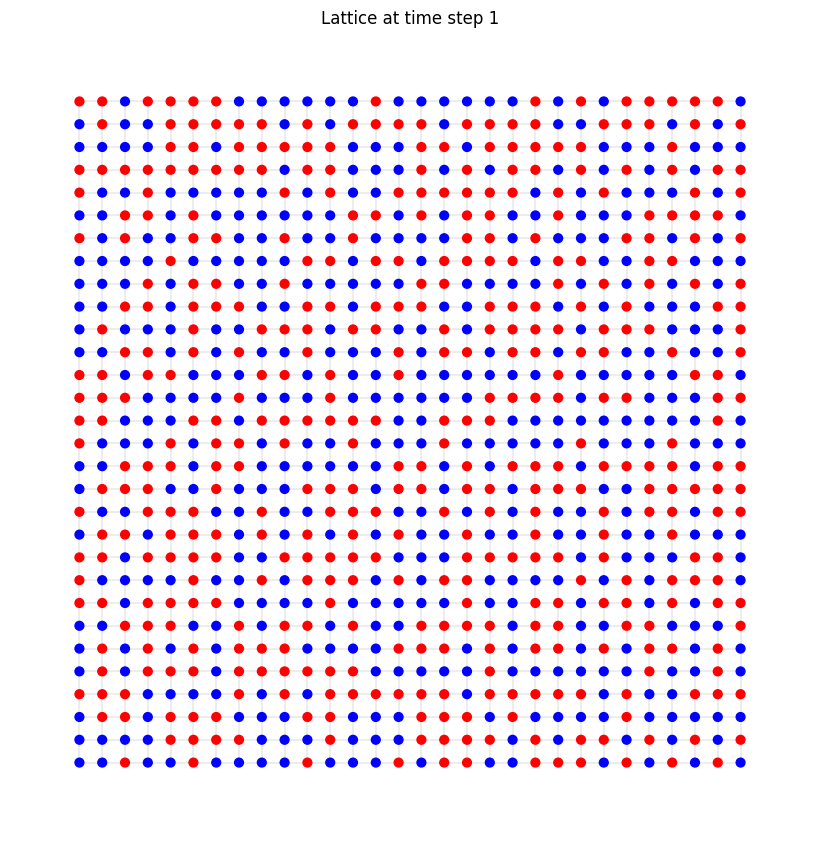

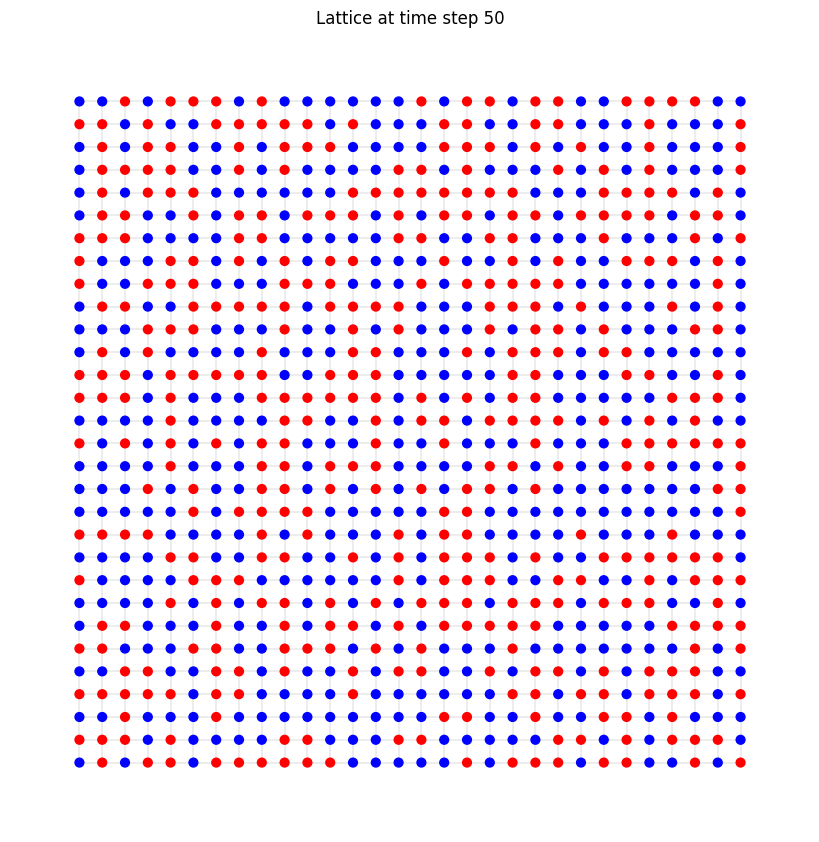

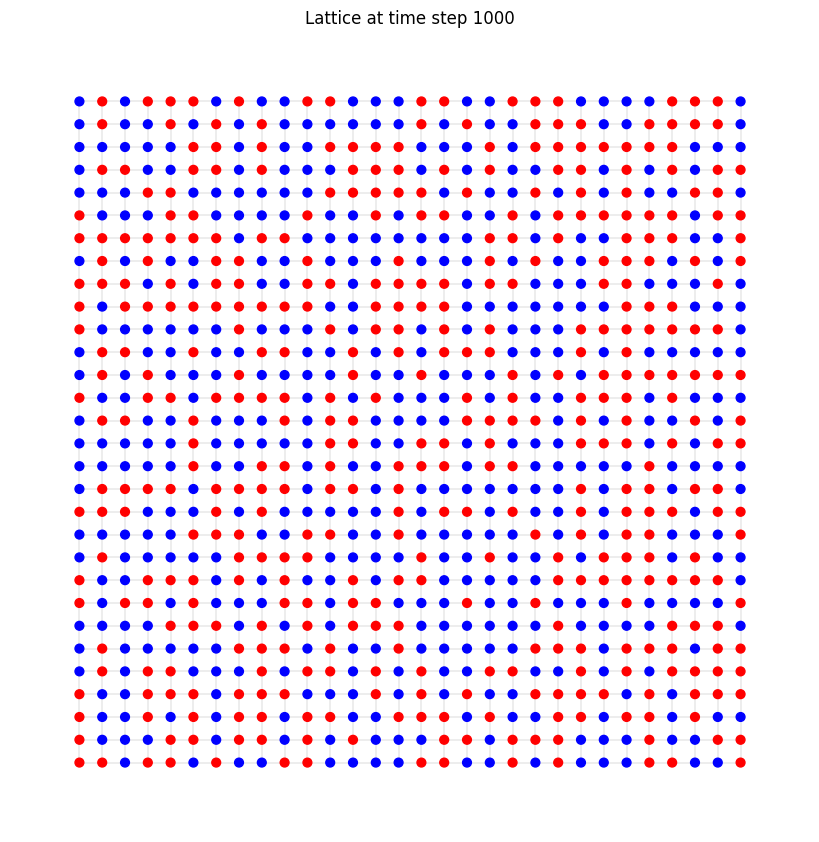

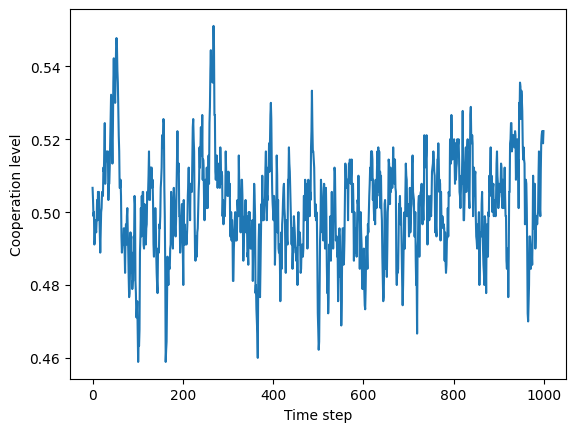

In [6]:

# Run the simulation and plot the final state
cooperation_levels, G = simulate()

# Plot the cooperation level over time
plt.plot(cooperation_levels)
plt.xlabel("Time step")
plt.ylabel("Cooperation level")
plt.show()
